## Andrew Byrnes: Fetch Rewards Coding Exercise - Data Analyst
### 2.2-FINAL_ANSWERS.ipynb

This notebook contains my submission for the Fetch Rewards Coding Exercise - Data Analyst. It is an edited and concise version of 2.1-EDA_first_pass.ipynb. I've added additional descriptive comments to my code, and removed some of the exploratory analysis present in the first pass. 

The content presented here should be considered as my final answers for the exercise.

### Data Sources
- fetch.db: SQLite file from notebook 1-Data_Prep
- fetch_db_erd.jpg: ERD image, documenting fetch.db schema designed and created in notebook 1-Data_Prep

### Changes
- 09-21-2022 : Set up notebook
- 09-25-2022 : added final version of answers, translating and editing from work in 2.1-EDA_first_pass.ipynb

In [1]:
import pandas as pd
from pathlib import Path
import os
from datetime import datetime
import sqlite3

### File Locations

In [2]:
today = datetime.today()
print(today)
db_path = Path.cwd() / "data" / "processed" / "fetch.db"
erd_fetch_db = Path.cwd() / "data" / "interim" / "fetch_db_erd.jpg" 

2022-09-25 14:18:20.673250


### Formatting and options

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns')

## First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

1-Data_Prep.ipynb captures my process from start to finish of reviewing the data, performing some transformations, and loading 4 tables of data into a SQLite database. 

I've structured the data as presented in this ERD:
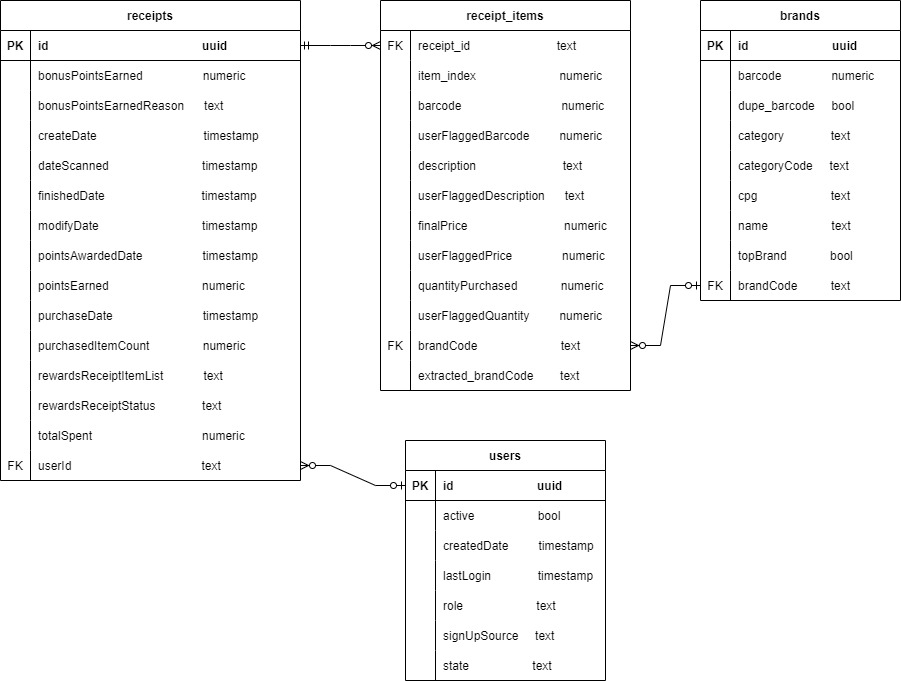
*Note: brands.brandCode <-> receipt_items.brandCode is not implemented as a zero or one to zero or many relationship in fetch.db as depicted above. There are duplicate values present in brands.brandCode. This needs to be accounted for when performing this join. If only brands.name is needed, a CTE selecting unique name, brandCode from brands would prevent duplicates.*

## Second: Write a query that directly answers a predetermined question from a business stakeholder
My format for sharing queries for this excercise is as follows:
- assign the sql query string to a variable, query
- create a sqlite3 connection to fetch.db
- execute the query and save the results to a pandas dataframe
- end with the cell returning the dataframe which presents the sql result viusally

###  What are the top 5 brands by receipts scanned for most recent month? & How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?
- both of these questions can be answered with one query

**Assumptions:**  
**"by receipts scanned"**: Only count a receipt once, even if it contains purchases from two distinct barcodes associated with the same brand, or two of the same barcode purchased multiple times on the same receipt. To account for this, we'll count distinct receipt ids as 'scanned receipts'

**Recent Month**: It looks like the receipts data was captured on 3/1/21 around 11pm. I'm going to assume 'most recent month' refers to the most recent complete month. I'm assuming a complete month can be indicated by the presence of values in the following month. In this case there is some data from March, so I'll assume February is the most recent, complete, month. With 444 records in February and 637 in January it seems safe to assume those are complete sets, relative to the other three months present.

**Answer:** 
- The top 5 brands by receipts scanned for February 2021 are; 
  1. Doritos 7 
  2. Heinz 4 
  3. Capri Sun 3 
  4. Huggies, SUAVE, Viva 2
    * With three brands all having 2 receipts scanned we would have to decide how to define top 5. This is technically the top 6 brands, three of them sharing the top 4 spot.
    
    
- When comparing to the previous month, an obvious difference is that top brands in January have significantly more receipts scanned than the top brands in February. This is because there are far fewer successful joins from receipts to brands for February's data. We'll explore this further in the Third section of the exercise.
- The top 5 brands by receipts scanned for January 2021 are;
  1. Kraft 43 
  2. Oscar Mayer 36 
  3. Doritos 32
  4. Huggies 28
  5. Pepsi 24

In [8]:
query = f"""
        -- There are dupe brandCodes which could lead to duplicates after a join - get a unique list of name, brandCode
        with unique_brands as (
            select
                DISTINCT name,
                brandCode
            from
                brands        
        ),
        
        -- Only count receipts once per brand, grouped by brand name and month
        b_by_r_scanned_month as (
            select 
                date(r.dateScanned, 'start of month') month,
                b.name,
                /* I only want to count a receipt once, even if there are multiple separate items purchased on the receipt 
                from the same brand */
                count(DISTINCT ri.receipt_id) as receipts_scanned
            from
                unique_brands b
                join receipt_items ri on coalesce(ri.brandCode, ri.extracted_brandCode) = b.brandCode
                join receipts r on r.id = ri.receipt_id
            group by
                month, name
            order by
                receipts_scanned desc
        ),
        
        /* Window function to rank brands by receipts_scanned high->low, partitioning/resetting the rank on month. I
        chose RANK() rather than ROW() because if two of the top brands have the same number of receipts I don't want 
        to arbitrarily assign a top position. 
        */
        receipts_ranked_month as (
            select
                -- ROW_NUMBER() OVER (PARTITION BY r.month ORDER BY receipts_scanned DESC) as brand_rank,
                RANK() OVER (PARTITION BY r.month ORDER BY receipts_scanned DESC) as brand_rank,
                r.month,
                r.name,
                r.receipts_scanned
            from
                b_by_r_scanned_month r
            order by
                brand_rank,
                month DESC
        )
        
        -- Final select clause, setting the filter to top 5, ie brand_rank < 6
        select
            *
        from
            receipts_ranked_month
        where
            brand_rank < 6
            and month between 
                    (
                    select
                        -- the start of the 2nd most recent month of complete data 
                        date(max(dateScanned), 'start of month', '-2 month')
                    from
                        receipts
                    )
                    
                    and
                    
                    (
                    select
                        -- the start of the most recent month of complete data 
                        date(max(dateScanned), 'start of month', '-1 month')
                    from
                        receipts
                    )
        order by
            month desc      
        """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,brand_rank,month,name,receipts_scanned
0,1,2021-02-01,Doritos,7
1,2,2021-02-01,Heinz,4
2,3,2021-02-01,Capri Sun,3
3,4,2021-02-01,Huggies,2
4,4,2021-02-01,SUAVE,2
5,4,2021-02-01,Viva,2
6,1,2021-01-01,Kraft,43
7,2,2021-01-01,Oscar Mayer,36
8,3,2021-01-01,Doritos,32
9,4,2021-01-01,Huggies,28


### When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
- There is no 'Accepted' status.
 - based on the other statuses (FINISHED, SUBMITTED, PENDING, FLAGGED) it seems logical that FINISHED and REJECTED are the final statuses for a receipt. I'm assuming that when complete, a SUBMITTED, PENDING, FLAGGED receipt will transition to either FINISHED or REJECTED.

With this in mind, I'll assume that 'Accepted' is synonymous with 'FINISHED'.

### When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
This question can easily be answered by adding one more aggregation to the query to answer the preceding question.

**Answer:**
- Average spend is higher for receipts with Status Accepted (`$`80.85) than Status Rejcted (`$`23.33)
- The total number of items purchased is higher for receipts with Status Accepted (8,184) than Status Rejcted (173)

In [9]:
query = f"""
        select
            -- case statement to format statuses inline with the question
            case 
                when r.rewardsReceiptStatus = 'FINISHED' then 'Accepted'
                when r.rewardsReceiptStatus = 'REJECTED' then 'Rejected'
                else r.rewardsReceiptStatus
            end as receipt_status,
            count(r.id) as number_receipts,
            -- printf("$%.2f", presents the value as a currency
            printf("$%.2f", sum(r.totalSpent)) as total_spent,
            printf("$%.2f", sum(r.totalSpent) / count(r.id)) as average_spent_per_receipt,
            sum(purchasedItemCount) as items_purchased
            
        from
            receipts r
        where
            -- only return the two statuses referenced
            r.rewardsReceiptStatus in ('FINISHED', 'REJECTED')
        group by
            receipt_status
        order by
            -- present 'average_spent_per_receipt' as a currency string, but order by the numeric value
            sum(r.totalSpent) / count(r.id) desc           
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,receipt_status,number_receipts,total_spent,average_spent_per_receipt,items_purchased
0,Accepted,518,$41882.53,$80.85,8184
1,Rejected,71,$1656.15,$23.33,173


### Which brand has the most spend among users who were created within the past 6 months?
**Assumptions:**  
- There is not a valid brandCode available for many of the items in receipts.rewardsReceiptItemList. This results in few matches when joining receipt_items to brands. With that in mind the following analysis is limited to items purchased with identifiable brands.  
- The past 6 months is defined as the most recent month present in the users data and the preceding 5 months.

**Answer:**  
- Huggies is the brand with the most spend (`$`2,222.92) among users who were created within the past 6 months.


In [11]:
query = f"""
        -- There are dupe brandCodes which could lead to duplicates after a join - get a unique list of name, brandCode
        with unique_brands as (
            select
                DISTINCT name,
                brandCode
            from
                brands        
        )
        select
            b.name as brand_name,
            -- printf("$%.2f", presents the value as a currency
            printf("$%.2f", sum(coalesce(ri.finalPrice, ri.userFlaggedPrice))) as spend
        from
            unique_brands b
            join receipt_items ri on coalesce(ri.brandCode, ri.extracted_brandCode) = b.brandCode
            join receipts r on r.id = ri.receipt_id
            join users u on u.id = r.userid       
        where
            -- extract and compare the start of month value for dates
            date(u.createdDate, 'start of month') BETWEEN
                                                        -- the start of the 6 month period (5 months prior to most recent month with data)
                                                        (
                                                        select
                                                            max(date(u.createdDate, 'start of month','-5 months'))
                                                        from
                                                            users u
                                                        )
                                                        AND
                                                        -- the end of the 6 month period (most recent month with data)
                                                        (
                                                        select
                                                            max(date(u.createdDate, 'start of month'))
                                                        from
                                                            users u
                                                        )
        group by
            brand_name
        order by
            -- I want to present 'spend' as a currency string, but order by the numeric value descending
            sum(coalesce(ri.finalPrice, ri.userFlaggedPrice)) desc
        -- only return the top 5 rows
        limit 5
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,brand_name,spend
0,Huggies,$2222.92
1,Miller Lite,$1455.00
2,Doritos,$735.76
3,KNORR,$718.06
4,Cracker Barrel Cheese,$703.50
